# Point Transformer
https://github.com/qq456cvb/Point-Transformers

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=False)

Mounted at /content/gdrive


In [2]:
import torch
!pip install open3d 1>/dev/null
%load_ext tensorboard

In [3]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import torch.optim as optim
import numpy as np
from google.colab import output
output.enable_custom_widget_manager()

!pip install ipympl 1>/dev/null
%matplotlib widget

import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith("2.1.") and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'
from pytorch3d.loss.chamfer import chamfer_distance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 983.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=6878740f75da2517f41998ff9cb4e396d56fc4d81773433c241a9542da0ab0e9
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31532 sha256=2c984cec72ae460d86a9784cf19d22db3cd6d315fe76247e73a0b9308d1dd3ec
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu121_pyt210/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 152.6 MB/s eta 0:00:00


In [4]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


In [5]:
#!git pull

In [6]:
from visuals.visuals_util import visualize_pointcloud, visualize_pointcloud_eval, visualize_pointcloud_eval_three

## Load dataset

In [7]:
from datasets.shapenet_data_pc import ShapeNet15kPointClouds

In [8]:
shapenet_location = "/content/gdrive/MyDrive/Developer/ShapeNetCore_pointclouds/ShapeNetCore.v2.PC15k"
tr_dataset = ShapeNet15kPointClouds(root_dir=shapenet_location,
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

val_dataset = ShapeNet15kPointClouds(root_dir=shapenet_location,
    categories=["airplane"], split='val',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

test_dataset = ShapeNet15kPointClouds(root_dir=shapenet_location,
    categories=["airplane"], split='test',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

len(tr_dataset), len(val_dataset), len(test_dataset)

Total number of data:2832
Min number of points: (train)2048 (test)2048
Total number of data:405
Min number of points: (train)2048 (test)2048
Total number of data:808
Min number of points: (train)2048 (test)2048


(2832, 405, 808)

In [9]:
batch_size = 5
train_dataloader = torch.utils.data.DataLoader(tr_dataset,
                                               batch_size=batch_size,
                                               sampler=None,
                                               shuffle=True is None,
                                               num_workers=1,
                                               drop_last=True)

val_dataloader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size=batch_size,
                                               sampler=None,
                                               shuffle=True is None,
                                               num_workers=1,
                                               drop_last=True)

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=batch_size,
                                               sampler=None,
                                               shuffle=True is None,
                                               num_workers=1,
                                               drop_last=True)

## Load model

In [10]:
%cd /content/gdrive/MyDrive/Developer
# !git clone https://github.com/qq456cvb/Point-Transformers
%cd Point-Transformers

/content/gdrive/MyDrive/Developer
/content/gdrive/MyDrive/Developer/Point-Transformers


In [11]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.1/151.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=7e3198c1914b74f4e0db386f6ecdb79d0ac85bbc37237e162da10b276342a6e3
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


### Point Transformer Model

In [12]:
%cd /content/gdrive/MyDrive/Developer/Point-Transformers

/content/gdrive/MyDrive/Developer/Point-Transformers


In [13]:

import torch
import torch.nn as nn
from pointnet_util import PointNetFeaturePropagation, PointNetSetAbstraction
from models.Hengshuang.transformer import TransformerBlock

class TransitionDown(nn.Module):
    def __init__(self, k, nneighbor, channels):
        super().__init__()
        self.sa = PointNetSetAbstraction(k, 0, nneighbor, channels[0], channels[1:], group_all=False, knn=True)

    def forward(self, xyz, points):
        return self.sa(xyz, points)


class TransitionUp(nn.Module):
    def __init__(self, dim1, dim2, dim_out):
        class SwapAxes(nn.Module):
            def __init__(self):
                super().__init__()

            def forward(self, x):
                return x.transpose(1, 2)

        super().__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(dim1, dim_out),
            SwapAxes(),
            nn.BatchNorm1d(dim_out),  # TODO
            SwapAxes(),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(dim2, dim_out),
            SwapAxes(),
            nn.BatchNorm1d(dim_out),  # TODO
            SwapAxes(),
            nn.ReLU(),
        )
        self.fp = PointNetFeaturePropagation(-1, [])

    def forward(self, xyz1, points1, xyz2, points2):
        feats1 = self.fc1(points1)
        feats2 = self.fc2(points2)
        feats1 = self.fp(xyz2.transpose(1, 2), xyz1.transpose(1, 2), None, feats1.transpose(1, 2)).transpose(1, 2)
        return feats1 + feats2


class Backbone(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        npoints, nblocks, nneighbor, n_c, d_points = cfg.num_point, cfg.model.nblocks, cfg.model.nneighbor, cfg.num_class, cfg.input_dim
        self.fc1 = nn.Sequential(
            nn.Linear(d_points, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        self.transformer1 = TransformerBlock(32, cfg.model.transformer_dim, nneighbor)
        self.transition_downs = nn.ModuleList()
        self.transformers = nn.ModuleList()
        for i in range(nblocks):
            channel = 32 * 2 ** (i + 1)
            self.transition_downs.append(TransitionDown(npoints // 4 ** (i + 1), nneighbor, [channel // 2 + 3, channel, channel]))
            self.transformers.append(TransformerBlock(channel, cfg.model.transformer_dim, nneighbor))
        self.nblocks = nblocks

    def forward(self, x):
        xyz = x[..., :3]
        points = self.transformer1(xyz, self.fc1(x))[0]

        xyz_and_feats = [(xyz, points)]
        for i in range(self.nblocks):
            xyz, points = self.transition_downs[i](xyz, points)
            points = self.transformers[i](xyz, points)[0]
            xyz_and_feats.append((xyz, points))
        return points, xyz_and_feats


class PointTransformerCls(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.backbone = Backbone(cfg)
        npoints, nblocks, nneighbor, n_c, d_points = cfg.num_point, cfg.model.nblocks, cfg.model.nneighbor, cfg.num_class, cfg.input_dim
        self.fc2 = nn.Sequential(
            nn.Linear(32 * 2 ** nblocks, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, n_c)
        )
        self.nblocks = nblocks

    def forward(self, x):
        points, _ = self.backbone(x)
        res = self.fc2(points.mean(1))
        return res


class PointTransformerSeg(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.backbone = Backbone(cfg)
        npoints, nblocks, nneighbor, n_c, d_points = cfg.num_point, cfg.model.nblocks, cfg.model.nneighbor, cfg.num_class, cfg.input_dim
        self.fc2 = nn.Sequential(
            nn.Linear(32 * 2 ** nblocks, 512),
            # nn.BatchNorm1d(512),  # Batch Normalization layer added
            nn.GELU(),
            nn.Linear(512, 512),
            # nn.BatchNorm1d(512),  # Batch Normalization layer added
            nn.GELU(),
            nn.Linear(512, 32 * 2 ** nblocks)
        )
        self.transformer2 = TransformerBlock(32 * 2 ** nblocks, cfg.model.transformer_dim, nneighbor)
        self.nblocks = nblocks
        self.transition_ups = nn.ModuleList()
        self.transformers = nn.ModuleList()
        for i in reversed(range(nblocks)):
            channel = 32 * 2 ** i
            self.transition_ups.append(TransitionUp(channel * 2, channel, channel))
            self.transformers.append(TransformerBlock(channel, cfg.model.transformer_dim, nneighbor))

        self.fc3 = nn.Sequential(
            nn.Linear(32, 64),
            # nn.BatchNorm1d(64),
            # nn.LeakyReLU(),
            nn.GELU(),
            nn.Linear(64, 64),
            # nn.BatchNorm1d(64),
            # nn.LeakyReLU(),
            nn.GELU(),
            nn.Linear(64, n_c)
        )

    def forward(self, x):
        input = x
        points, xyz_and_feats = self.backbone(x)
        xyz = xyz_and_feats[-1][0]
        points = self.transformer2(xyz, self.fc2(points))[0]

        for i in range(self.nblocks):
            points = self.transition_ups[i](xyz, points, xyz_and_feats[- i - 2][0], xyz_and_feats[- i - 2][1])
            xyz = xyz_and_feats[- i - 2][0]
            points = self.transformers[i](xyz, points)[0]

        return input + self.fc3(points)

In [14]:
# from models.Hengshuang.model import PointTransformerSeg

class DotDict:
  pass

cfg = DotDict()
cfg.num_point = 2048
cfg.model = DotDict()
cfg.model.nneighbor=32
cfg.model.nblocks=4
cfg.model.transformer_dim=512
cfg.num_class=3
cfg.input_dim = 3

model = PointTransformerSeg(cfg)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
_ = model.to(device)

# Losses
training_losses = []
val_losses = []
linearize_input = False

# Early Stopping (patience)
best_val_loss = np.inf
patience = 10
patience_counter = 0

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"total params: {total_params}, trainable params: {trainable_params}")

total params: 19393699, trainable params: 19393699


In [15]:
def add_random_noise(point_cloud, mean=0, std=0.025, device="cuda"):
    noise = torch.normal(mean, std, size=point_cloud.size()).to(device)
    point_cloud_noise = point_cloud + noise
    return point_cloud_noise

In [16]:
from pytorch3d.loss.chamfer import chamfer_distance

def residuals_chamfer_distance(ground_truth, input, residual):
  return chamfer_distance(ground_truth, input + residual)[0]

In [17]:
from torch.nn import MSELoss
pc = tr_dataset[0]["train_points"].to(device)
print(MSELoss()(pc, add_random_noise(pc, 0.025)))
print(MSELoss()(pc, add_random_noise(pc, 0.05)))

tensor(0.0012, device='cuda:0')
tensor(0.0032, device='cuda:0')


In [18]:
from torch.nn import MSELoss

def residual_l2_loss(ground_truth, input, residual):
  return MSELoss()(ground_truth, input + residual)


print(residual_l2_loss(pc, add_random_noise(pc), add_random_noise(torch.zeros(size=pc.shape).to(device))))

tensor(0.0013, device='cuda:0')


## Train


In [19]:
# %tensorboard --logdir runs

In [20]:
# TensorBoard Logging with model's name and current date
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
current_time = datetime.now().strftime('%b%d_%H-%M-%S')
model_name = 'PointTransformer-Refinement-Part'
log_dir = f"runs/{model_name}_{current_time}"
writer = SummaryWriter(log_dir=log_dir)

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


In [21]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes

import functools
from tqdm import tqdm
import itertools
from datetime import datetime

residual_loss_fct = residuals_chamfer_distance
# residual_loss_fct = residual_l2_loss

noise_fct = functools.partial(add_random_noise, std=0.05)

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


In [22]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
# optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, 0.98)

In [23]:
# input = torch.unsqueeze(tr_dataset[0]['train_points'], dim=0).to(device)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_directory = f"output-models/point_transformer/{timestamp}"
!mkdir {model_directory}

try:
  for epoch in range(100):
    total_train_loss = 0
    total_val_loss = 0

    # Train
    model.train()
    for batch in tqdm(train_dataloader):
      # Overfit on single pointcloud

      input = batch["train_points"].to(device)
      noised_input = noise_fct(input)
      # print(noised_input[0][0])

      optimizer.zero_grad()
      output = model(noised_input)

      loss = chamfer_distance(input, output)[0]

      loss.backward()
      optimizer.step()

      total_train_loss += loss.item()


    epoch_train_loss = total_train_loss / len(train_dataloader)
    training_losses.append(epoch_train_loss)

    lr_scheduler.step()

    # free gpu memory:
    del output
    del loss
    optimizer.zero_grad()
    torch.cuda.empty_cache()
    import gc
    gc.collect()


    model.eval()
    for batch in tqdm(val_dataloader):
      # Overfit on single pointcloud
      input = batch["train_points"].to(device)
      noised_input = noise_fct(input)
      # print(noised_input[0][0])

      with torch.no_grad():
        output = model(noised_input)

        loss = chamfer_distance(input, output)[0]

        total_val_loss += loss.item()

    epoch_val_loss = total_val_loss / len(val_dataloader)
    val_losses.append(epoch_val_loss)

    writer.add_scalar('Loss/train', epoch_train_loss, epoch)
    writer.add_scalar('Loss/val', epoch_val_loss, epoch)


    # Check for improvement
    if epoch_val_loss < best_val_loss:
      best_val_loss = epoch_val_loss
      patience_counter = 0  # reset the patience counter
    else:
      patience_counter += 1
      print(f"No improvement in validation loss for {patience_counter} epochs.")

    # Break the loop if patience exceeded
    if patience_counter >= patience:
      print("Stopping early due to no improvement in validation loss.")
      break


    # Save the model
    model_save_path = f"{model_directory}/Point-Transformer-e_{epoch+1:03d}.pth"
    torch.save(model.state_dict(), model_save_path)

    print(f"Epoch {epoch+1},  Training Loss: {epoch_train_loss:.8f}")
except Exception as e:
  from google.colab import runtime
  runtime.unassign()

from google.colab import runtime
runtime.unassign()

100%|██████████| 81/81 [01:02<00:00,  1.30it/s]


Epoch 1,  Training Loss: 0.00590036


100%|██████████| 81/81 [01:02<00:00,  1.31it/s]


No improvement in validation loss for 1 epochs.
Epoch 2,  Training Loss: 0.00547312


100%|██████████| 81/81 [01:00<00:00,  1.34it/s]


Epoch 3,  Training Loss: 0.00538027


100%|██████████| 81/81 [01:00<00:00,  1.35it/s]


Epoch 4,  Training Loss: 0.00534774


100%|██████████| 81/81 [01:00<00:00,  1.34it/s]


No improvement in validation loss for 1 epochs.
Epoch 5,  Training Loss: 0.00535086


100%|██████████| 81/81 [01:00<00:00,  1.35it/s]


Epoch 6,  Training Loss: 0.00533524


100%|██████████| 81/81 [01:00<00:00,  1.35it/s]


No improvement in validation loss for 1 epochs.
Epoch 7,  Training Loss: 0.00533250


100%|██████████| 81/81 [00:59<00:00,  1.36it/s]


No improvement in validation loss for 2 epochs.
Epoch 8,  Training Loss: 0.00532839


100%|██████████| 81/81 [00:59<00:00,  1.36it/s]


No improvement in validation loss for 3 epochs.
Epoch 9,  Training Loss: 0.00532184


 15%|█▌        | 85/566 [02:38<14:57,  1.87s/it]


KeyboardInterrupt: 

Epoch 1,  Training Loss: 0.00609474


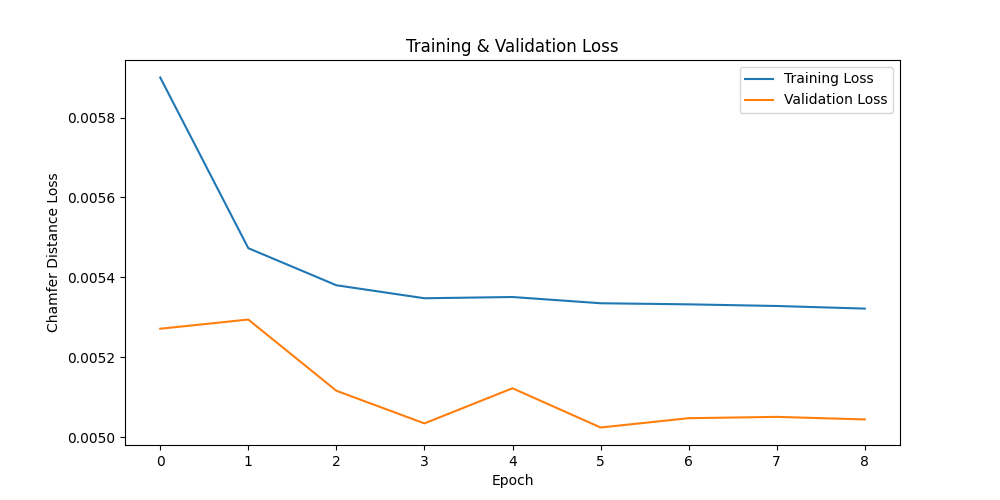

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Chamfer Distance Loss')
plt.legend()
plt.show()

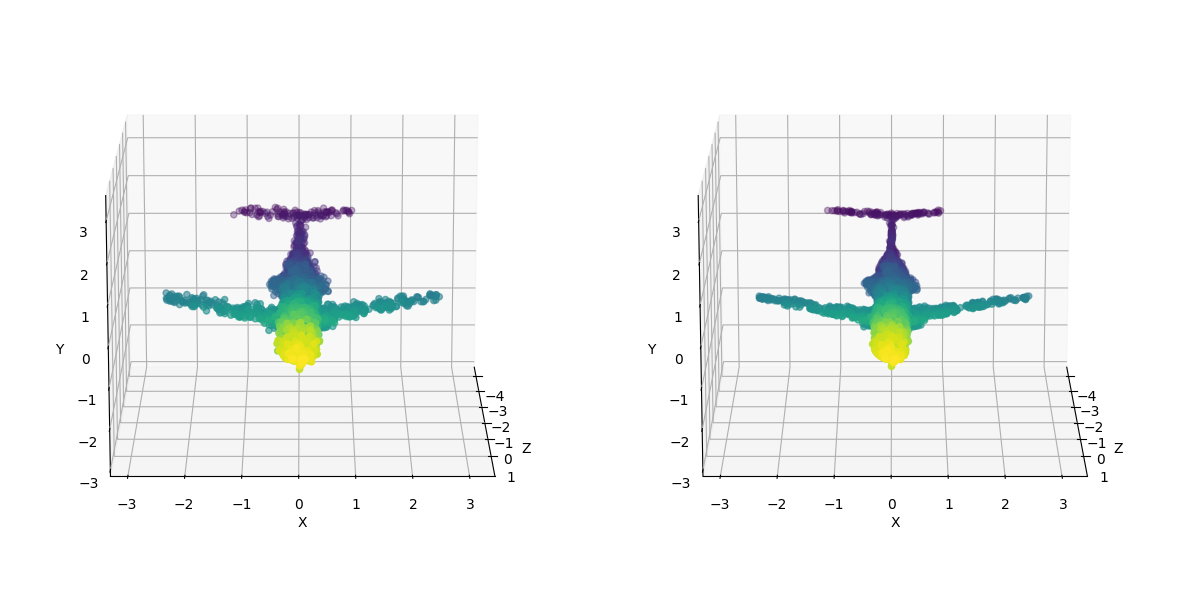

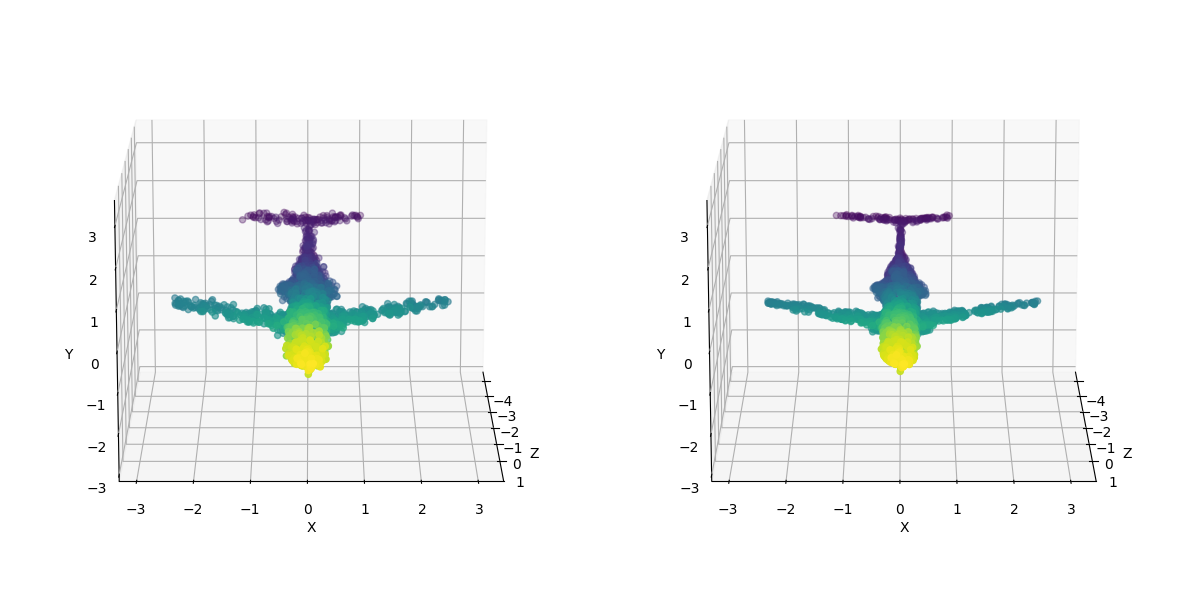

In [25]:
model.eval()
with torch.no_grad():
  input = tr_dataset[0]['train_points'].unsqueeze(0).to(device)
  noised_input = noise_fct(input)
  # print(noised_input[0][0])

  output = model(noised_input)

visualize_pointcloud_eval(noised_input, output)

In [27]:
!mv {model_directory} {model_directory}_pt_global_refinment_no_residuals

In [ ]:
try: optimizer.zero_grad()
except: pass
try: del output
except: pass
try: del loss
except: pass
try: del input
except: pass
try:  del noised_input
except: pass
try: del optimizer
except: pass
try: del lr_scheduler
except: pass
torch.cuda.empty_cache()
import gc
gc.collect()
!nvidia-smi

## Visualize example

In [ ]:
!ls output-models/point_transformer

In [ ]:
model.eval()
# input = torch.unsqueeze(tr_dataset[0]['train_points'], dim=0).to(device)
noised_input = noise_fct(input)

with torch.no_grad():
  output = model(noised_input)

loss = residuals_chamfer_distance(ground_truth=input, input=noised_input, residual=output)
# print(loss)

print(f"`{cfg.num_point=}, {cfg.model.nneighbor=}, {cfg.model.nblocks=}, {cfg.model.transformer_dim=}, {cfg.num_class=}, {cfg.input_dim=}`\n")

print(f"noise CD: `{chamfer_distance(input, noised_input)[0]}`, refined CD: `{chamfer_distance(input, noised_input + output)[0]}`")

`cfg.num_point=2048, cfg.model.nneighbor=32, cfg.model.nblocks=4, cfg.model.transformer_dim=512, cfg.num_class=3, cfg.input_dim=3`
`noise CD: 0.002761125098913908, refined CD: 0.003036821261048317`

`cfg.num_point=2048, cfg.model.nneighbor=32, cfg.model.nblocks=4, cfg.model.transformer_dim=512, cfg.num_class=3, cfg.input_dim=3`
`noise CD: 0.002727443352341652, refined CD: 0.002919104415923357`

### New input per iteration:
`cfg.num_point=2048, cfg.model.nneighbor=32, cfg.model.nblocks=4, cfg.model.transformer_dim=512, cfg.num_class=3, cfg.input_dim=3`
`noise CD: 0.002834647661074996, refined CD: 0.003089092904701829`

### GELU
`cfg.num_point=2048, cfg.model.nneighbor=32, cfg.model.nblocks=4, cfg.model.transformer_dim=512, cfg.num_class=3, cfg.input_dim=3`
`noise CD: 0.0028214456979185343, refined CD: 0.00297591183334589`

### noise std=0.05
`cfg.num_point=2048, cfg.model.nneighbor=32, cfg.model.nblocks=4, cfg.model.transformer_dim=512, cfg.num_class=3, cfg.input_dim=3`
noise CD: `0.007028569467365742`, refined CD: `0.006310636177659035`

In [ ]:
visualize_pointcloud(output.squeeze().cpu())
visualize_pointcloud_eval_three(input.squeeze().cpu(), noised_input.squeeze().cpu(), (noised_input + output).squeeze().cpu())

## Load previous model

In [ ]:
model_save_path = "/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/output-models/point_transformer/2024-01-30_23-46-44/Point-Transformer-e_027.pth"

In [ ]:
# load best previous model:
model.load_state_dict(torch.load(model_save_path))
_ = model.eval()

## Eval with PVD output

In [28]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
from datasets.pvd_data_pc import ShapeNet15kPointCloudsPVD

dataset_pvd = ShapeNet15kPointCloudsPVD(root_dir="./custom-dataset",
    categories=["airplane"], split='train',
    tr_sample_size=2048,
    te_sample_size=2048,
    scale=1.,
    normalize_per_shape=False,
    normalize_std_per_axis=False,
    random_subsample=True)

dataloader_pvd = torch.utils.data.DataLoader(dataset_pvd,
                                               batch_size=5,
                                               sampler=None,
                                               shuffle=True is None,
                                               num_workers=1,
                                               drop_last=True)
print(len(dataset_pvd))

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
Total number of data:400
Min number of points: (train)2048 (test)2048
400


In [ ]:
print(dataset_pvd[0])
visualize_pointcloud(dataset_pvd[0]['test_points'])

In [ ]:
!git pull

In [30]:
dataset_pvd[i]['test_points'].to(device).unsqueeze(0).shape
with torch.no_grad():
  output = model(input)
print(output.shape)
export_pointcloud_to_pts(output, "/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/visuals/point-transformer/test")

NameError: name 'i' is not defined

In [ ]:
# timestamp = "2024-01-30_23-46-44"

In [34]:
from visuals.visuals_util import rotate_point_cloud_x, rotate_point_cloud_z, rotate_point_cloud_y, visualize_pointcloud_eval, save_fig, visualize_pointcloud_eval_three, visualize_pointcloud
from utils.export import export_pointcloud_to_asc, export_pointcloud_to_pts
from pathlib import Path
from google.colab import files

model.eval()

base_path = Path(f"./visuals/point-transformer/{timestamp}/")
base_path.mkdir(parents=True, exist_ok=True)

for i in range(10):
  input = dataset_pvd[i]['test_points'].to(device).unsqueeze(0)
  with torch.no_grad():
    output = model(input)
  loss = chamfer_distance(input, output)[0]
  print(f"{i}, residual CD: {loss}")
  # print(input.shape, output.shape, input.mean(), output.mean(), input.std(), output.std())
  visualize_pointcloud_eval(input, output)
  # instance_path = f"{(base_path / f'{i:02d}').absolute()}-"
  # torch.save(input.squeeze(), instance_path + "input.pth")
  # torch.save(output.squeeze(), instance_path + "residuals.pth")
  # torch.save((input + output).squeeze(), instance_path + "refined_output.pth")

# visualize_pointcloud_eval(rotate_point_cloud_y(input.squeeze().cpu(), -45), rotate_point_cloud_y((input + output).squeeze().cpu(), -45))
# visualize_pointcloud_eval(rotate_point_cloud_y(input.squeeze().cpu(), 45), rotate_point_cloud_y((input + output).squeeze().cpu(), 45))

Output hidden; open in https://colab.research.google.com to view.

## Eval like in PVD

In [35]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes

input_array = []

for batch in val_dataloader:
  input = batch["test_points"].to("cuda")
  input_array.append(input)

/content/gdrive/MyDrive/Developer/coarse-to-fine-shapes


In [36]:
output_array = []

model.eval()
for batch in tqdm(dataloader_pvd):
  input = batch["train_points"].to(device)
  noised_input = noise_fct(input)

  with torch.no_grad():
    output = model(noised_input)
    output_array.append(output)

100%|██████████| 80/80 [00:58<00:00,  1.37it/s]


In [37]:
print(input_array[0][0].shape)

torch.Size([2048, 3])


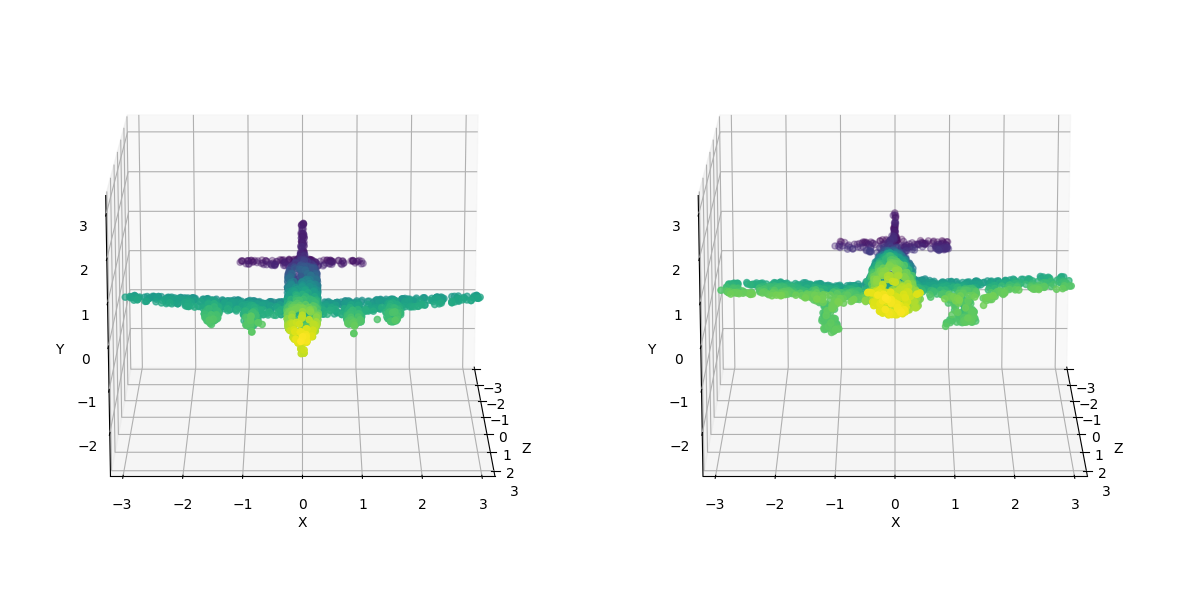

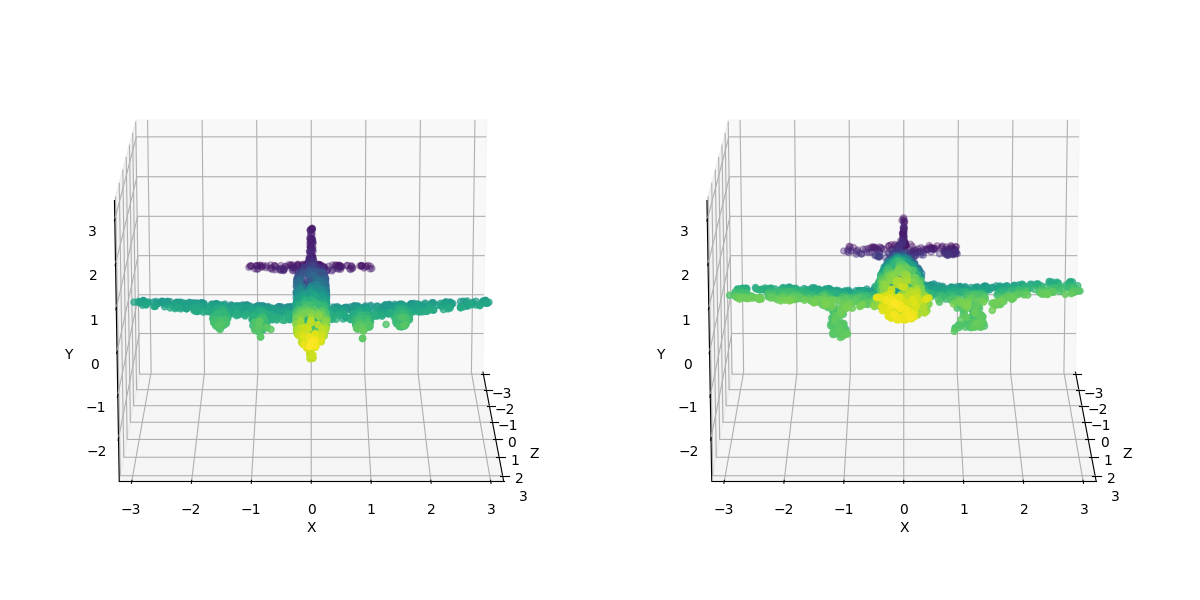

In [38]:
visualize_pointcloud_eval(input_array[0][0], output_array[0][0])

In [40]:
print(len(input_array), len(output_array))
print(input_array[0].shape, output_array[0].shape)

81 80
torch.Size([5, 2048, 3]) torch.Size([5, 2048, 3])


In [41]:
from pathlib import Path
input_pcs = torch.stack(input_array).view(405, 2048, 3)
output_pcs = torch.stack(output_array).view(400, 2048, 3)

base = Path(f"./eval-results/point-transformer/{model_directory}_global_refinment")
base.mkdir(parents=True, exist_ok=True)
torch.save(input_pcs, f"{base}/input_pcs.pt")
torch.save(output_pcs, f"{base}/output_pcs.pt")

In [42]:
!mv /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/eval-results/point-transformer/output-models/point_transformer/2024-02-02_19-09-12_global_refinment /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes/eval-results/point-transformer/2024-02-02_19-09-12_global_refinment

In [ ]:
!git pull

In [ ]:
!git add {base}
!git commit -m "add point transformer eval tensors"
!git push

In [ ]:
from google.colab import runtime
runtime.unassign()

## Utils

In [ ]:
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
!git status

In [ ]:
!git add visuals/point-transformer/

In [ ]:
!git commit -m "Add PointTransformer global refinment results"
!git push

In [ ]:
from google.colab import files
zip_name = f"{base_path}.zip"
!zip -r {zip_name} {str(base_path)}
files.download(zip_name)

In [ ]:
# Save the model
%cd /content/gdrive/MyDrive/Developer/coarse-to-fine-shapes
from datetime import datetime
model_save_path = f"output-models/point_transformer/PointTransformer-{datetime.now().strftime('%Y-%m-%d_%H-%M')}.pth"
torch.save(model.state_dict(), model_save_path)
!git add .
!git status

In [ ]:
!git add .
!git commit -m "Add new model"
!git push

In [ ]:
# input = torch.unsqueeze(tr_dataset[0]['train_points'], dim=0).to(device)[:,:1024]
# with torch.no_grad():
#   output = model(noised_input)
# print(input.shape, output.shape)
# visualize_pointcloud(output.cpu())

In [ ]:
input = input.squeeze().cpu()
device="cpu"
visualize_pointcloud_eval_three(input, add_random_noise(input), add_random_noise(input, std=0.1))

In [ ]:
from google.colab import runtime
runtime.unassign()